In [1]:
# --- Standard Library & General Science ---
import warnings
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.sparse import dok_matrix, csr_matrix
from scipy.sparse.linalg import eigsh
from IPython.display import display

# --- Graph Theory & Visualization ---
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# --- Quantum Chemistry & Simulation (Non-Qiskit) ---
import pyscf
import pyscf.cc
import pyscf.mcscf
from pyscf import ao2mo, gto, mcscf, scf

# --- Qiskit: Core & Circuit ---
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2, TwoLocal, efficient_su2
from qiskit.circuit.library import (
    RXXGate, RYYGate, RZZGate, RZGate,
    QAOAAnsatz, PauliEvolutionGate
)
from qiskit.synthesis import LieTrotter
from qiskit.quantum_info import SparsePauliOp, Statevector

# --- Qiskit: Quantum Information ---
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator

# --- Qiskit: Transpiler & Providers ---
from qiskit.transpiler import Layout, CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

# --- Qiskit: Primitives & Runtime ---
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)
from qiskit_ibm_runtime.debug_tools import Neat

# --- Qiskit: Visualization ---
from qiskit.visualization import plot_histogram
# Qiskit Nature
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition, LineLattice
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.operators import FermionicOp

# Qiskit Algorithms & Solvers
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver

# Qiskit Primitives & Simulator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_aer import AerSimulator

In [2]:
# --- 1. HAMILTONIAN (4x1) ---
def build_fermi_hubbard_4x1_op(t, U):
    num_sites = 4
    num_spin_orbitals = 2 * num_sites
    terms = {}

    # Mapping: Spin-Separated
    def up_index(site): return site
    def down_index(site): return site + num_sites

    edges = [(0, 1), (1, 2), (2, 3)]

    # Hopping
    for (i, j) in edges:
        # Spin UP
        p, q = up_index(i), up_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t
        # Spin DOWN
        p, q = down_index(i), down_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t

    # Interaction
    for i in range(num_sites):
        u_idx, d_idx = up_index(i), down_index(i)
        op_str = f"+_{u_idx} -_{u_idx} +_{d_idx} -_{d_idx}"
        terms[op_str] = terms.get(op_str, 0.0) + U

    return FermionicOp(terms, num_spin_orbitals=num_spin_orbitals)

In [3]:
# --- 2. CÁC HÀM CỔNG VẬT LÝ ---
def apply_hop(qc, theta, q1, q2):
    qc.rxx(theta, q1, q2)
    qc.ryy(theta, q1, q2)

# --- 3. ANSATZ (HVA) ---
def create_4x1_pure_hva_ansatz(reps=4):
    num_sites = 4
    num_qubits = 8
    qc = QuantumCircuit(num_qubits)

    # --- State Preparation (Hartree-Fock / Néel State) ---
    qc.x([0, 2, 5, 7])
    qc.barrier()

    # Tham số hóa cho HVA
    params_per_rep = 4 + 6
    total_params = reps * params_per_rep
    theta = ParameterVector('θ', length=total_params)
    p_idx = 0

    edges = [(0, 1), (1, 2), (2, 3)]

    for layer in range(reps):

        # === 1. HVA Interaction  ===
        for i in range(num_sites):
            qc.rzz(theta[p_idx], i, i + 4)
            p_idx += 1

        # === 2. HVA Hopping ===

        # -- Spin Up Hopping --
        for (i, j) in edges:
            apply_hop(qc, theta[p_idx], i, j)
            p_idx += 1

        # -- Spin Down Hopping --
        for (i, j) in edges:
            apply_hop(qc, theta[p_idx], i + 4, j + 4)
            p_idx += 1

        qc.barrier()

    return qc

--- FERMI-HUBBARD 4x1 (HVA) ---
----------------------------------------------------------------------
U/t        | VQE Energy      | Exact Energy    | Error     
----------------------------------------------------------------------
0.0        | -3.854070       | -4.472136       | 0.618066  
1.0        | -3.072398       | -3.575366       | 0.502967  
2.0        | -2.441082       | -2.875943       | 0.434860  
4.0        | -1.616653       | -1.953145       | 0.336492  


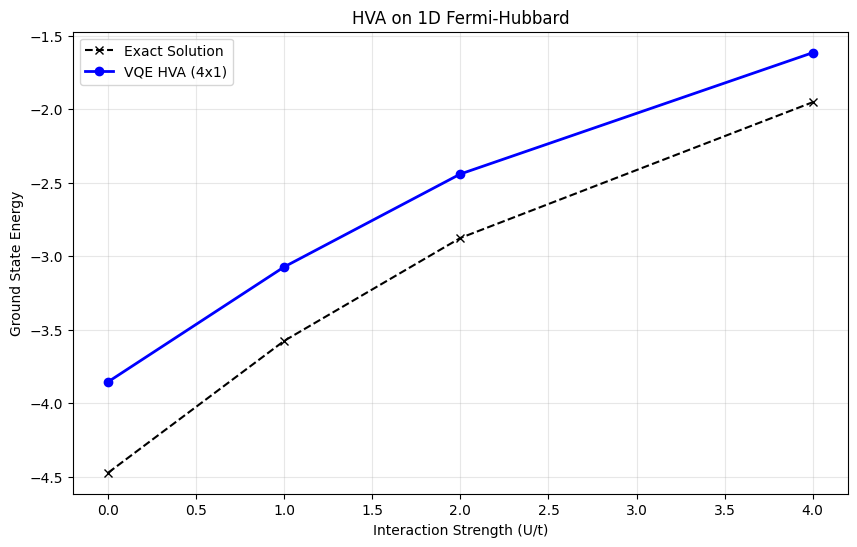


--- Circuit Structure Check (HVA) ---


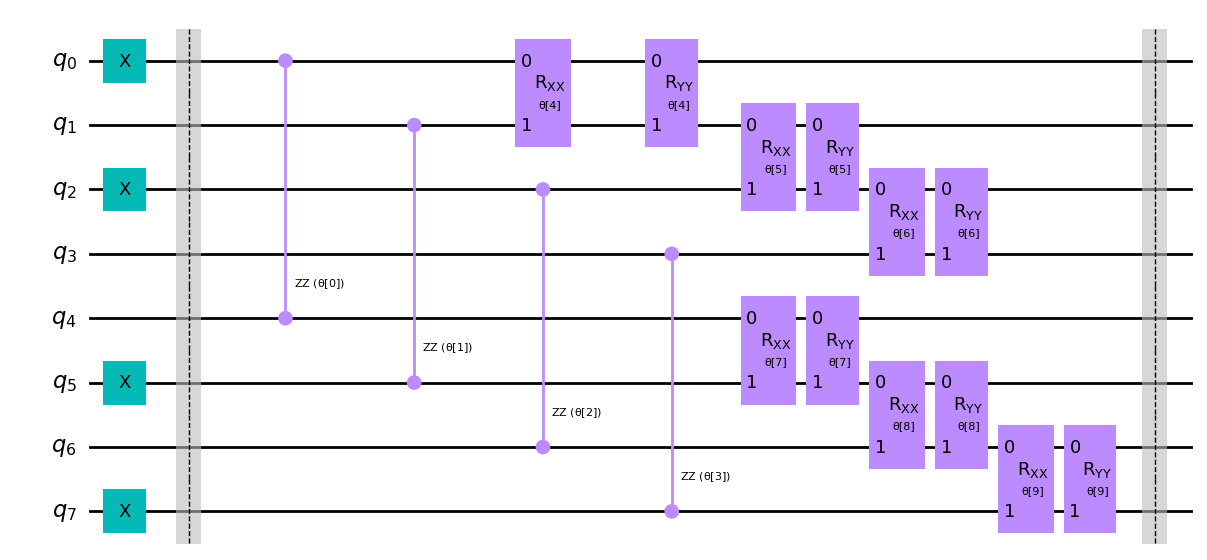

In [4]:
# --- 4. VQE ENGINE ---
def run_vqe(hamiltonian, ansatz, initial_params=None):
    estimator = Estimator()

    def cost_func(params):
        valid_params = params[:ansatz.num_parameters]
        job = estimator.run([(ansatz, hamiltonian, valid_params)])
        return float(job.result()[0].data.evs)

    num_params = ansatz.num_parameters
    if initial_params is not None:
        if len(initial_params) >= num_params:
            initial_point = initial_params[:num_params]
        else:
            initial_point = np.pad(initial_params, (0, num_params - len(initial_params)))
        initial_point += np.random.uniform(-0.02, 0.02, num_params)
    else:
        initial_point = np.random.uniform(-0.01, 0.01, num_params)

    optimizer = SLSQP(maxiter=5000, ftol=1e-06)
    result = optimizer.minimize(fun=cost_func, x0=initial_point)
    return result.fun, result.x

# --- 5. MAIN ---
def main():
    t = 1.0
    U_values = [0.0, 1.0, 2.0, 4.0]
    reps = 4

    print(f"--- FERMI-HUBBARD 4x1 (HVA) ---")
    print("-" * 70) # Adjusted length
    print(f"{'U/t':<10} | {'VQE Energy':<15} | {'Exact Energy':<15} | {'Error':<10}")
    print("-" * 70) # Adjusted length

    mapper = JordanWignerMapper()
    prev_params = None
    vqe_Es, exact_Es = [], []

    for U in U_values:
        # 1. Setup
        ferm_op = build_fermi_hubbard_4x1_op(t, U)
        qubit_op = mapper.map(ferm_op)

        # 2. Exact Solver
        num_op_ferm = FermionicOp({f"+_{i} -_{i}": 1.0 for i in range(8)}, num_spin_orbitals=8)
        num_op = mapper.map(num_op_ferm)
        filter_fn = lambda s, v, a: np.isclose(a['NumberOp'][0], 4, atol=1e-2)
        solver = NumPyMinimumEigensolver(filter_criterion=filter_fn)
        exact_res = solver.compute_minimum_eigenvalue(operator=qubit_op, aux_operators={'NumberOp': num_op})
        exact_E = exact_res.eigenvalue.real
        exact_Es.append(exact_E)

        # 3. Run VQE (HVA)
        ansatz = create_4x1_pure_hva_ansatz(reps=reps)
        vqe_E, opt_params = run_vqe(qubit_op, ansatz, initial_params=prev_params)

        vqe_Es.append(vqe_E)
        prev_params = opt_params

        print(f"{U:<10} | {vqe_E:<15.6f} | {exact_E:<15.6f} | {abs(vqe_E - exact_E):<10.6f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(U_values, exact_Es, 'k--x', label='Exact Solution')
    plt.plot(U_values, vqe_Es, 'b-o', label='VQE HVA (4x1)', linewidth=2)
    plt.xlabel('Interaction Strength (U/t)')
    plt.ylabel('Ground State Energy')
    plt.title('HVA on 1D Fermi-Hubbard')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Draw Circuit
    print("\n--- Circuit Structure Check (HVA) ---")
    sample_qc = create_4x1_pure_hva_ansatz(reps=1)
    display(sample_qc.draw('mpl', style='clifford', fold=-1))

if __name__ == "__main__":
    main()